<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/Stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
from multiprocessing import Pool

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def page_to_df(self, page):
    url = "https://finance.naver.com/item/sise_day.nhn?code=" + self.code + "&page=" + str(page)
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    tr = bs_obj.find_all("tr", {'onmouseover':'mouseOver(this)', 'onmouseout':"mouseOut(this)"})
    data_dict = {}
    for i in range(10):
      try: 
        spans = tr[i].find_all('span')
        lines = [span.get_text() for span in spans]
        lines = list(map(lambda x: x.replace(',',''), lines))

        objdate = datetime.datetime.strptime(lines[0], '%Y.%m.%d')
        data_dict[objdate] = lines[1:]
      except:
        break
      
    df = pd.DataFrame.from_dict(data_dict).transpose()
    df.columns = ['Close','_','Open','High','Low','Volume']
    df = df.drop(columns="_")
    return df

  def crawl(self, start_page:int=1, end_page:int=26):
    df = self.page_to_df(start_page)
    # 1 page = 10 days
    for i in range(start_page, end_page): 
      try: 
        if (any(self.page_to_df(i).index != self.page_to_df(i-1).index)):
          df = df.append(self.page_to_df(i))
          print('.', end = '')
          if (i%100==0):
            print(i)
        else:
          break
      except:
        df = df.append(self.page_to_df(i))
    df = df.sort_index(axis = 0) 
    for i in ['Close', 'Open', 'High', 'Low', 'Volume']:
      df[i] = df[i].astype(int)
    return df

  def get_data(self, page:int=100):
    with Pool(page) as p:
        li = p.starmap(self.crawl, [(x,x) for x in range(page,0,-1)])
    return pd.concat(li)
 
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df
  
  def get_code_name(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + str(self.code)
    result = requests.get(url, headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'})
    bs_obj = BeautifulSoup(result.content, "html.parser")
    name = bs_obj.find_all("div", {'class':'wrap_company'})
    return name[0].find_all('h2')[0].get_text()

In [64]:
# z - normalization
from scipy import stats
def z_norm(x):
  return stats.zscore(x)

# min-max normalization
def min_max_norm(x):
  return (change - min(change))/(max(change)-min(change))

# numpy version normalization
def norm(x):
  norm = np.linalg.norm(x)
  return np.round(x/norm, 16)

In [65]:
stock = Stock('051900')

In [66]:
price_df = stock.get_data(500)
price_df

,Close,Open,High,Low,Volume
2001-04-25,13650,11900,13650,11900,26150
2001-04-26,15650,15650,15650,15650,87500
2001-04-27,17950,17950,17950,16600,2002100
2001-04-30,18000,18900,19500,17500,1296800
2001-05-02,20700,18500,20700,17750,1081050
...,...,...,...,...,...
2021-05-11,1561000,1596000,1596000,1557000,36517
2021-05-12,1530000,1556000,1560000,1522000,42804
2021-05-13,1519000,1525000,1539000,1516000,36979
2021-05-14,1521000,1521000,1530000,1515000,23542


In [67]:
fundamental_df = stock.get_fundamental()
fundamental_df

,2018.12(Y),2019.12(Y),2020.12(Y),2021.12(E)(Y),2019.12(M),2020.03(M),2020.06(M),2020.09(M),2020.12(M),2021.03(E)(M)
sales,67475.00,76854.00,78445.00,86417.00,20133.00,18964.00,17832.00,20706.00,20944.00,20638.00
operating profit,10393.00,11764.00,12209.00,13758.00,2410.00,3337.00,3033.00,3276.00,2563.00,3562.00
net income,6923.00,7882.00,8131.00,9392.00,1338.00,2342.00,2046.00,2317.00,1426.00,2447.00
operating margin,15.40,15.31,15.56,15.92,11.97,17.60,17.01,15.82,12.24,17.26
net margin,10.26,10.26,10.37,10.87,6.65,12.35,11.47,11.19,6.81,11.86
roe,20.98,20.32,17.92,18.05,20.32,20.00,18.79,18.12,17.92,NaN
debt ratio,46.80,53.26,40.26,NaN,53.26,50.42,46.13,43.32,40.26,NaN
quick ratio,79.22,79.99,79.33,NaN,79.99,78.73,67.99,82.28,79.33,NaN
reserve ratio,4132.20,4822.48,5534.21,NaN,4822.48,4874.03,5099.47,5356.00,5534.21,NaN
eps,38534.00,43916.00,45018.00,52203.00,7512.00,13016.00,11282.00,12823.00,7897.00,13852.00


In [68]:
def find_date(year, month):
  start = str(year) + '-' + str(month) + '-' + '01'
  end = str(year) + '-' + str(month+1) + '-' + '01'
  return price_df.loc[start:end].index.values[0]

In [69]:
price_info = price_df.loc[[find_date(year,1) for year in range(2018,2022)]]['Close']
price_info

2018-01-02    1200000
2019-01-02    1081000
2020-01-02    1266000
2021-01-04    1612000
Name: Close, dtype: int64

In [70]:
temp_df = fundamental_df

In [75]:
price_info

2018-01-02    1200000
2019-01-02    1081000
2020-01-02    1266000
2021-01-04    1612000
Name: Close, dtype: int64

In [73]:
temp_df.loc['price'] = price_info

In [74]:
temp_df

,2018.12(Y),2019.12(Y),2020.12(Y),2021.12(E)(Y),2019.12(M),2020.03(M),2020.06(M),2020.09(M),2020.12(M),2021.03(E)(M),price
sales,67475.00,76854.00,78445.00,86417.00,20133.00,18964.00,17832.00,20706.00,20944.00,20638.00,NaN
operating profit,10393.00,11764.00,12209.00,13758.00,2410.00,3337.00,3033.00,3276.00,2563.00,3562.00,NaN
net income,6923.00,7882.00,8131.00,9392.00,1338.00,2342.00,2046.00,2317.00,1426.00,2447.00,NaN
operating margin,15.40,15.31,15.56,15.92,11.97,17.60,17.01,15.82,12.24,17.26,NaN
net margin,10.26,10.26,10.37,10.87,6.65,12.35,11.47,11.19,6.81,11.86,NaN
roe,20.98,20.32,17.92,18.05,20.32,20.00,18.79,18.12,17.92,NaN,NaN
debt ratio,46.80,53.26,40.26,NaN,53.26,50.42,46.13,43.32,40.26,NaN,NaN
quick ratio,79.22,79.99,79.33,NaN,79.99,78.73,67.99,82.28,79.33,NaN,NaN
reserve ratio,4132.20,4822.48,5534.21,NaN,4822.48,4874.03,5099.47,5356.00,5534.21,NaN,NaN
eps,38534.00,43916.00,45018.00,52203.00,7512.00,13016.00,11282.00,12823.00,7897.00,13852.00,NaN


In [33]:
year_dates = [datetime.datetime.strptime(x[:7],'%Y.%m')  for x in fundamental_df.columns.values][:4]
year_dates = [np.datetime64(x) for x in year_dates]
year_dates

[numpy.datetime64('2018-12-01T00:00:00.000000'),
 numpy.datetime64('2019-12-01T00:00:00.000000'),
 numpy.datetime64('2020-12-01T00:00:00.000000'),
 numpy.datetime64('2021-12-01T00:00:00.000000')]

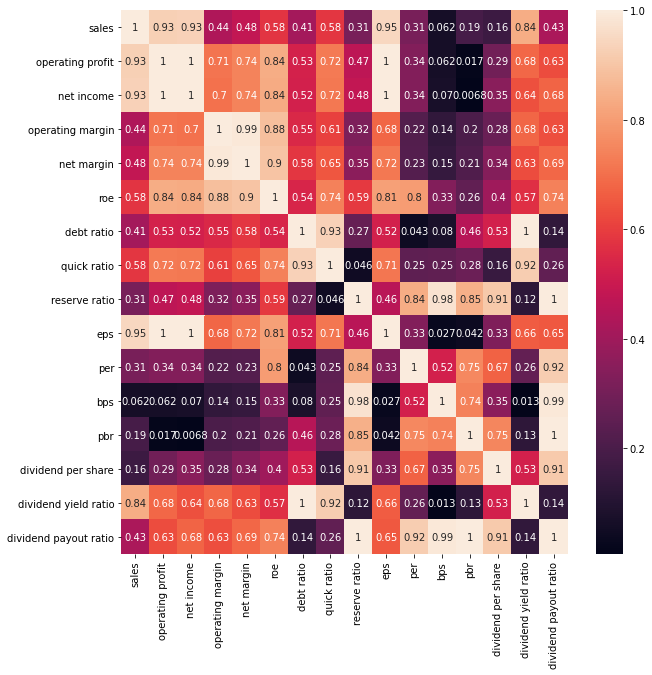

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation heatmap
corrmat = fundamental_df.transpose().corr().abs() 
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, annot = True)